In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 128  

def initialise_projections(in_dim, out_dim):
    """
    create projections for Q, K, V.
    """
    return nn.Linear(in_dim, out_dim).to(DEVICE)

def pairwise_similarities(Q, K):
    """
    Compute dot product attention.
    """
    return torch.matmul(Q, K.transpose(-2, -1))

def attention_scaled(scores, head_dim):
    """
    Scale the raw attention scores.
    """
    return scores / math.sqrt(head_dim)

def attention_softmax(scaled_scores):
    """
    Normalize the scaled raw attention scores with softmax.
    """
    return F.softmax(scaled_scores, dim=-1)

def compute_outputs(attn_weights, V):
    """
    Get outputs as a weighted sum of values by attention scores.
    """
    return torch.matmul(attn_weights, V)

def make_causal_mask(seq_len):
    """
    Create a mask matrix that masks future context for the attention.
    """
    mask = torch.tril(torch.ones(seq_len, seq_len, device=DEVICE)).bool()
    return mask

def apply_causal_mask(scores, mask):
    """
    Apply mask to attention.
    """
    scores = scores.masked_fill(~mask, float('-inf'))
    return scores

def split_heads(x, num_heads):
    """
    Splitting the input across multiple heads.
    """
    batch, seq_len, embed_dim = x.size()
    head_dim = embed_dim // num_heads
    x = x.view(batch, seq_len, num_heads, head_dim)
    return x.transpose(1, 2)

def merge_heads(x):
    """
    Reversing splitting action of function split_heads().
    """
    batch, num_heads, seq_len, head_dim = x.size()
    embed_dim = num_heads * head_dim
    x = x.transpose(1, 2).contiguous().view(batch, seq_len, embed_dim)
    return x

def self_attention(x, proj_q, proj_k, proj_v, num_heads):
    """
    Self-attention block.
    """
    Q = proj_q(x)  
    K = proj_k(x)
    V = proj_v(x)
    Q = split_heads(Q, num_heads)  
    K = split_heads(K, num_heads)
    V = split_heads(V, num_heads)
    scores = pairwise_similarities(Q, K)  
    head_dim = Q.size(-1)
    scores = attention_scaled(scores, head_dim)
    seq_len = x.size(1)
    mask = make_causal_mask(seq_len)
    mask = mask.unsqueeze(0).unsqueeze(0)  
    scores = apply_causal_mask(scores, mask)
    attn_weights = attention_softmax(scores)
    output = compute_outputs(attn_weights, V)
    output = merge_heads(output)
    return output, attn_weights

def split_heads_qkv(Q, K, V, num_heads):
    """
    Split Q, K, V across multiple heads.
    """
    return split_heads(Q, num_heads), split_heads(K, num_heads), split_heads(V, num_heads)

In [ ]:
#padding
def pad_to_length(tokens, max_len, tokenizer):
    """
    Pad tokens to a fixed length.
    """
    if len(tokens) < max_len:
        tokens = tokens + [tokenizer["<PAD>"]] * (max_len - len(tokens))
    else:
        tokens = tokens[:max_len]
    return tokens

def tokenize(sentence, pad_to_len=None, tokenizer=None, include_stop=True):
    """
    Tokenize a sentence.
    """
    tokens = sentence.split()
    if include_stop:
        tokens = ["<START>"] + tokens + ["<STOP>"]
    else:
        tokens = ["<START>"] + tokens
    if pad_to_len:
        tokens = pad_to_length(tokens, pad_to_len, tokenizer)
    token_ids = [tokenizer.get(token, tokenizer["<PAD>"]) for token in tokens]

    return token_ids

def decode(tokens, tokenizer_inv, end_at_stop=True, omit_pad=True):
    """
    Decode tokens to text.
    """
    words = []
    for token in tokens:
        word = tokenizer_inv.get(token, "")
        if omit_pad and word == "<PAD>":
            continue
        if end_at_stop and word == "<STOP>":
            break
        words.append(word)
    return " ".join(words)

def load_and_preprocess_data():
    
    # with open("/kaggle/input/shakespearedataset2/shakespear_train.txt", "r") as f:
    #     lines_train = f.readlines()
    # with open("/kaggle/input/shakespearedataset2/shakespear_dev.txt", "r") as f:
    #     lines_dev = f.readlines()
    # with open("/kaggle/input/shakespearedataset2/shakespear_dev.txt", "r") as f:
    #     lines_test = f.readlines()

    with open("D:\\Me\\Sems\\Sem_6\\NLP\\ASS_3\\QN1\\shakespear_train.txt", "r") as f:
        lines_train = f.readlines()
    with open("D:\\Me\\Sems\\Sem_6\\NLP\\ASS_3\\QN1\\shakespear_dev.txt", "r") as f:
        lines_dev = f.readlines()
    with open("D:\\Me\\Sems\\Sem_6\\NLP\\ASS_3\\QN1\\shakespear_dev.txt", "r") as f:
        lines_test = f.readlines()

    # "D:\\Me\\Sems\\Sem_6\\NLP\\ASS_3\\QN1\\shakespear_dev.txt"
    tokens_train = [line.split() for line in lines_train]

    def flat(tokens):
        return [token for sublist in tokens for token in sublist]

    token_counts = Counter(flat(tokens_train))

    special_tokens = ["<PAD>", "<START>", "<STOP>"]

    vocab = special_tokens + sorted(token_counts.keys())
    tokenizer = {token: idx for idx, token in enumerate(vocab)}
    tokenizer_inv = {idx: token for token, idx in tokenizer.items()}

    def process_line(line):
        line = line.strip()
        tokens = line.split()
        tokens = ["<START>"] + tokens + ["<STOP>"]
        if len(tokens) < MAX_LEN:
            tokens = tokens + ["<PAD>"] * (MAX_LEN - len(tokens))
        else:
            tokens = tokens[:MAX_LEN]
        token_ids = [tokenizer.get(token, tokenizer["<PAD>"]) for token in tokens]
        return token_ids

    data_train = [process_line(line) for line in lines_train]
    data_val = [process_line(line) for line in lines_dev]

    train_dataset = [(tokens[:-1], tokens[1:]) for tokens in data_train]
    val_dataset = [(tokens[:-1], tokens[1:]) for tokens in data_val]

    return train_dataset, val_dataset, tokenizer, tokenizer_inv

In [7]:
@torch.no_grad()
def evaluate_losses(data, model, tokenizer, bs=32, progress=True, pad_to_len=MAX_LEN):
    it = range(0, len(data), bs)
    if progress:
        it = tqdm(it)
    out = []
    for b_start in it:
        batch = slice(b_start, b_start + bs)
        tokens = torch.tensor(
            [tokenize(t, pad_to_len=pad_to_len, tokenizer=tokenizer) for t in data[batch]],
            dtype=torch.long
        ).to(DEVICE)
        X_tokens, y_tokens = tokens[:, :-1].contiguous(), tokens[:, 1:].contiguous()
        model.eval()
        logits, _ = model(X_tokens)
        log_probs = F.log_softmax(logits, dim=-1)
        y_log_probs = torch.gather(log_probs, 2, y_tokens[..., None])[..., 0]
        for i in range(y_tokens.shape[0]):
            not_pad = y_tokens[i] != tokenizer["<PAD>"]
            loss = -y_log_probs[i, not_pad].mean()
            out.append(loss.item())
    return out

def generate_text(model, tokenizer, tokenizer_inv, context="", gen_tokens=10, temperature=0.6):
    """
    Generate a fixed number of tokens using the trained model.
    """
    tokens = tokenize(context, pad_to_len=None, tokenizer=tokenizer, include_stop=False)
    tokens = torch.tensor(tokens, dtype=torch.long, device=DEVICE).unsqueeze(0)   
    model.eval()
    with torch.no_grad():
        for _ in range(gen_tokens):
            logits, _ = model(tokens)
            last_logits = logits[:, -1, :] / temperature
            probs = F.softmax(last_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            tokens = torch.cat([tokens, next_token], dim=1)
            if next_token.item() == tokenizer.get("<STOP>", -1):
                break
    generated = decode(tokens.squeeze(0).tolist(), tokenizer_inv, end_at_stop=True, omit_pad=True)
    return generated


In [8]:
class TransformerLM(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, ff_hidden, dropout=0.1, max_len=MAX_LEN):
        super(TransformerLM, self).__init__()
        self.embed_dim = embed_dim
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_embedding = nn.Embedding(max_len, embed_dim)
        self.layers = nn.ModuleList([TransformerBlock(embed_dim, num_heads, ff_hidden, dropout) for _ in range(num_layers)])
        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.max_len = max_len
        self._init_weights()

    def _init_weights(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        batch_size, seq_len = x.size()
        token_embeddings = self.token_embedding(x)
        positions = torch.arange(0, seq_len, device=DEVICE).unsqueeze(0)
        pos_embeddings = self.pos_embedding(positions)
        x = token_embeddings + pos_embeddings
        x = self.dropout(x)
        attn_weights_all = []
        for layer in self.layers:
            x, attn_weights = layer(x)
            attn_weights_all.append(attn_weights)
        x = self.ln_f(x)
        logits = self.head(x)
        return logits, attn_weights_all

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden, dropout=0.1):
        super(TransformerBlock, self).__init__()
        self.mha = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.ln1 = nn.LayerNorm(embed_dim)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_hidden),
            nn.ReLU(),
            nn.Linear(ff_hidden, embed_dim),
            nn.Dropout(dropout)
        )
        self.ln2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_output, attn_weights = self.mha(x)
        x = self.ln1(x + attn_output)
        ff_output = self.ff(x)
        x = self.ln2(x + ff_output)
        return x, attn_weights

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be divisible by number of heads."
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.proj_q = nn.Linear(embed_dim, embed_dim)
        self.proj_k = nn.Linear(embed_dim, embed_dim)
        self.proj_v = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch, seq_len, embed_dim = x.size()
        Q = self.proj_q(x)
        K = self.proj_k(x)
        V = self.proj_v(x)
        Q = split_heads(Q, self.num_heads)
        K = split_heads(K, self.num_heads)
        V = split_heads(V, self.num_heads)
        scores = pairwise_similarities(Q, K)
        scores = attention_scaled(scores, self.head_dim)
        mask = make_causal_mask(seq_len)
        mask = mask.unsqueeze(0).unsqueeze(0)  
        scores = apply_causal_mask(scores, mask)
        attn_weights = attention_softmax(scores)
        attn_weights = self.dropout(attn_weights)
        out = compute_outputs(attn_weights, V)
        out = merge_heads(out)
        out = self.out_proj(out)
        return out, attn_weights


In [9]:

def train_model(model, train_dataset, val_dataset, tokenizer, tokenizer_inv, epochs=10, batch_size=32, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer["<PAD>"])
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        epoch_losses = []

        for i in range(0, len(train_dataset), batch_size):
            batch = train_dataset[i:i+batch_size]
            batch_input = [sample[0] for sample in batch]
            batch_target = [sample[1] for sample in batch]
            batch_input = torch.tensor(batch_input, dtype=torch.long, device=DEVICE)
            batch_target = torch.tensor(batch_target, dtype=torch.long, device=DEVICE)
            optimizer.zero_grad()
            logits, _ = model(batch_input)
            loss = criterion(logits.view(-1, logits.size(-1)), batch_target.view(-1))
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        train_loss = sum(epoch_losses) / len(epoch_losses)
        train_losses.append(train_loss)

        
        model.eval()
        val_epoch_losses = []
        with torch.no_grad():
            for i in range(0, len(val_dataset), batch_size):
                batch = val_dataset[i:i+batch_size]
                batch_input = [sample[0] for sample in batch]
                batch_target = [sample[1] for sample in batch]
                batch_input = torch.tensor(batch_input, dtype=torch.long, device=DEVICE)
                batch_target = torch.tensor(batch_target, dtype=torch.long, device=DEVICE)
                logits, _ = model(batch_input)
                loss = criterion(logits.view(-1, logits.size(-1)), batch_target.view(-1))
                val_epoch_losses.append(loss.item())
        val_loss = sum(val_epoch_losses) / len(val_epoch_losses)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}: Train Loss = {train_loss}, Val Loss = {val_loss}")

        sample_text = generate_text(model, tokenizer, tokenizer_inv, context="", gen_tokens=10)
        print(f"Sample text: {sample_text}")

    return train_losses, val_losses



In [ ]:
train_dataset, val_dataset, tokenizer, tokenizer_inv = load_and_preprocess_data()


vocab_size = len(tokenizer)
embed_dim = 256
num_heads = 4
num_layers = 6
ff_hidden = 1024
dropout = 0.1
epochs = 15
batch_size = 32
lr = 1e-4

# Initialize model
model = TransformerLM(vocab_size, embed_dim, num_heads, num_layers, ff_hidden, dropout, MAX_LEN)
model = model.to(DEVICE)
print(model)


TransformerLM(
  (token_embedding): Embedding(12574, 256)
  (pos_embedding): Embedding(128, 256)
  (layers): ModuleList(
    (0-5): 6 x TransformerBlock(
      (mha): MultiHeadAttention(
        (proj_q): Linear(in_features=256, out_features=256, bias=True)
        (proj_k): Linear(in_features=256, out_features=256, bias=True)
        (proj_v): Linear(in_features=256, out_features=256, bias=True)
        (out_proj): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): ReLU()
        (2): Linear(in_features=1024, out_features=256, bias=True)
        (3): Dropout(p=0.1, inplace=False)
      )
      (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
  )
  (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (head): Linear(in_features=256,

Epoch 1: Train Loss = 7.023700351838942, Val Loss = 5.988530054325011
Sample text: <START> shalt : : , -- to , , , I
Epoch 2: Train Loss = 6.0936109276560995, Val Loss = 5.610894726543892
Sample text: <START> !
Epoch 3: Train Loss = 5.754719522092249, Val Loss = 5.3498498288596545
Sample text: <START> If , To ,
Epoch 4: Train Loss = 5.542622502748069, Val Loss = 5.247107133632753
Sample text: <START> It you , sir , I I you my mayst
Epoch 5: Train Loss = 5.39107997696121, Val Loss = 5.1563945863305065
Sample text: <START> AUTOLYCUS : Then will you you , sick , I
Epoch 6: Train Loss = 5.2622838438331305, Val Loss = 5.078668547839653
Sample text: <START> ISABELLA : I good matter .
Epoch 7: Train Loss = 5.149972845981647, Val Loss = 5.016983567214593
Sample text: <START> PAULINA : No , neither a merry very words .
Epoch 8: Train Loss = 5.052249422321072, Val Loss = 4.946473656631097
Sample text: <START> ESCALUS : So not , sir , I think I
Epoch 9: Train Loss = 4.967051613640476, Val Loss = 

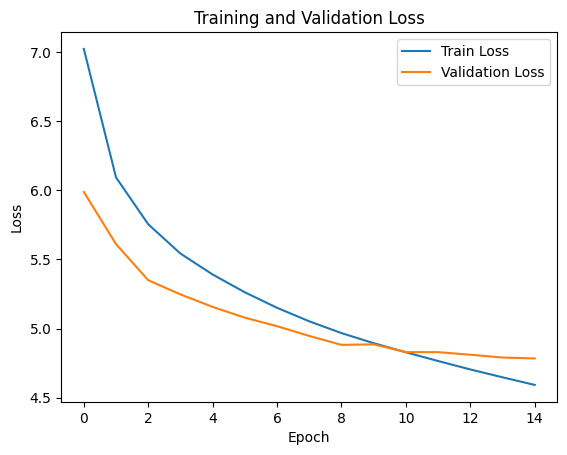

Model saved as transformer_lm.pth


In [ ]:
train_losses, val_losses = train_model(model, train_dataset, val_dataset, tokenizer, tokenizer_inv, epochs, batch_size, lr)

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.savefig("/kaggle/working/loss_plot.png")
plt.show()

torch.save(model.state_dict(), "/kaggle/working/transformer_lm.pth")
print("Model saved as transformer_lm.pth")




In [ ]:
with open("/kaggle/input/shakespearedataset2/shakespear_dev.txt", "r") as f:
    lines_test = f.readlines()
test_losses = evaluate_losses(lines_test, model, tokenizer, bs=batch_size, progress=False, pad_to_len=MAX_LEN)
test_perplexity = torch.exp(torch.tensor(sum(test_losses)/len(test_losses)))
print(f"\nTest perplexity: {test_perplexity.item()}")


Test perplexity: 80.21376037597656


In [16]:
import warnings as w
w.filterwarnings('ignore')

def inference(model_path, test_file, tokenizer, tokenizer_inv, gen_tokens=10, temperature=0.6):
    def load_model(filepath, vocab_size, embed_dim, num_heads, num_layers, ff_hidden, dropout=0.1, max_len=MAX_LEN):
        model = TransformerLM(vocab_size, embed_dim, num_heads, num_layers, ff_hidden, dropout, max_len)
        model.load_state_dict(torch.load(filepath, map_location=DEVICE))
        model.to(DEVICE)
        model.eval()
        return model

    with open(test_file, "r") as f:
        lines_test = f.readlines()

    vocab_size = len(tokenizer)

    embed_dim = 256
    num_heads = 4
    num_layers = 6
    ff_hidden = 1024
    dropout = 0.1
    epochs = 15
    batch_size = 32
    lr = 1e-4


    model = load_model(model_path, vocab_size, embed_dim, num_heads, num_layers, ff_hidden, dropout, MAX_LEN)

    losses = evaluate_losses(lines_test, model, tokenizer, bs=32, progress=True, pad_to_len=MAX_LEN)
    avg_loss = sum(losses) / len(losses)
    perplexity = torch.exp(torch.tensor(avg_loss)).item()

    generated_texts = []
    for line in lines_test[:5]: 
        generated_text = generate_text(model, tokenizer, tokenizer_inv, context=line, gen_tokens=20)

        generated_texts.append(generated_text)

    return generated_texts, perplexity



model_path = "D:\\Me\\Sems\\Sem_6\\NLP\\ASS_3\\QN1\\transformer_lm.pth"
test_file = "D:\\Me\\Sems\\Sem_6\\NLP\\ASS_3\\QN1\\shakespear_dev.txt"
train_dataset, val_dataset, tokenizer, tokenizer_inv = load_and_preprocess_data()

generated_texts, ppl = inference(model_path, test_file, tokenizer, tokenizer_inv)

with open(test_file, "r") as f:
    lines_test = f.readlines()

print(f"Perplexity: {ppl}")
for i, text in enumerate(generated_texts):
    print("Context lines", i+1, ":", lines_test[5-i])
    print(f"Generated Text {i+1}: {text}\n")


100%|██████████| 41/41 [00:02<00:00, 20.34it/s]


Perplexity: 80.21376037597656
Context lines 1 : DUKE VINCENTIO : And you , good brother father .

Generated Text 1: <START> , if there be no remedy for it , but that you will needs buy and sell men and women like beasts , we shall have all the world drink brown and white bastard .

Context lines 2 : 'Bless you , good father friar .

Generated Text 2: <START> DUKE VINCENTIO : O heavens !

Context lines 3 : ELBOW : Come your way , sir .

Generated Text 3: <START> what stuff is here POMPEY : 'T was never merry world since , of two , the was put down , and the worser allowed by order of law a gown to keep him warm ; and with and too , to signify , that craft , being richer than innocency , stands for the .

Context lines 4 : what stuff is here POMPEY : 'T was never merry world since , of two usuries , the merriest was put down , and the worser allowed by order of law a furred gown to keep him warm ; and furred with fox and lamb-skins too , to signify , that craft , being richer than innoce

In [ ]:
def predict_masked_words(model, sentence, word_to_idx, idx_to_word, device="cpu", max_len=2):
    model.eval()

    tokens = sentence.strip().split()
    input_indices = []
    mask_positions = []

    for i, word in enumerate(tokens):
        if word == "<MASK>":
            input_indices.append(word_to_idx["<PAD>"])
            mask_positions.append(i)
        else:
            input_indices.append(word_to_idx.get(word, word_to_idx["<PAD>"]))  

    input_tensor = torch.tensor([input_indices], dtype=torch.long).to(device)  

    with torch.no_grad():
        logits = model(input_tensor)[0] 

    predictions = []
    for pos in mask_positions:
        logits_at_pos = logits[0, pos]  
        probs = F.softmax(logits_at_pos, dim=0)
        predicted_idx = torch.argmax(probs).item()
        predicted_word = idx_to_word[predicted_idx]
        predictions.append(predicted_word)

    return predictions
